In [ ]:
#We upload the Kaggle Json for download the data.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arshadperampalli5068","key":"2d96dc283e1b692fea09b3c86dca5d57"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d 'mohammedabdeldayem/the-fake-or-real-dataset'

Dataset URL: https://www.kaggle.com/datasets/mohammedabdeldayem/the-fake-or-real-dataset
License(s): GNU Lesser General Public License 3.0
100% 16.0G/16.0G [01:42<00:00, 792MB/s] 
100% 16.0G/16.0G [01:42<00:00, 168MB/s]


In [ ]:
!unzip the-fake-or-real-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: for-rerec/for-rerecorded/training/real/recording12954.wav_norm_mono.wav  
  inflating: for-rerec/for-rerecorded/training/real/recording12955.wav_norm_mono.wav  
  inflating: for-rerec/for-rerecorded/training/real/recording12956.wav_norm_mono.wav  
  inflating: for-rerec/for-rerecorded/training/real/recording12957.wav_norm_mono.wav  
  inflating: for-rerec/for-rerecorded/training/real/recording12958.wav_norm_mono.wav  
  inflating: for-rerec/for-rerecorded/training/real/recording12959.wav_norm_mono.wav  
  inflating: for-rerec/for-rerecorded/training/real/recording12961.wav_norm_mono.wav  
  inflating: for-rerec/for-rerecorded/training/real/recording12962.wav_norm_mono.wav  
  inflating: for-rerec/for-rerecorded/training/real/recording12965.wav_norm_mono.wav  
  inflating: for-rerec/for-rerecorded/training/real/recording12966.wav_norm_mono.wav  
  inflating: for-rerec/for-rerecorded/training/real/recording12967.wav_norm_mon

In [ ]:
!pip install torch torchaudio transformers librosa --quiet
!apt-get install ffmpeg -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [ ]:
# Standard Python libraries
import os
import random
import pandas as pd
import numpy as np
import itertools
#PyTorch and related
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from IPython.display import Audio, display
#scikit-learn for metrics and utilities.
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report

)
from sklearn.utils.class_weight import compute_class_weight
# Matplotlib for visualization
import matplotlib.pyplot as plt
# Transformers library for pretrained models
from transformers import AutoProcessor, AutoFeatureExtractor, AutoModelForAudioClassification

In [ ]:
# Define root directory
root_dir = "/content/for-rerec/for-rerecorded"
# Function to create a unified DataFrame
def create_combined_dataframe():
  data = []
  for subset in ["training", "validation", "testing"]: # Combine all subsets
      subset_dir = os.path.join(root_dir, subset)
      for label, label_dir in enumerate (["fake", "real"]):
          folder = os.path.join(subset_dir, label_dir)
          for file_name in os.listdir (folder):
              if file_name.endswith(".wav"):
                  data.append({"audio_path": os.path.join(folder, file_name), "label": label})
  return pd.DataFrame(data)
# Create the combined DataFrame
combined_df = create_combined_dataframe()
print (f"Total samples in the combined dataset: {len(combined_df)}\n")
print("Combined DataFrame sample:")
print (combined_df.head())
# Split data into training, validation, and testing sets
train_df, temp_df = train_test_split(
    combined_df,
    test_size=0.4, # 40% for validation and testing
    stratify=combined_df ["label"], # Ensure balanced splits
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5, # Split remaining 40% equally between validation and testing
    stratify=temp_df["label"], # Ensure balanced splits
    random_state=42
)
#Function to display class distribution
def display_class_distribution (df, dataset_name):
    counts = df["label"].value_counts()
    print(f" {dataset_name} set class distribution:")
    print(f"Fake: {counts[0]} samples")
    print(f"Real: {counts[1]} samples")
    print(f"Total: {len (df)} samples\n")
# Display class distribution for each set
display_class_distribution (train_df, "Training")
display_class_distribution(val_df, "Validation")
display_class_distribution(test_df, "Testing")

Total samples in the combined dataset: 13268

Combined DataFrame sample:
                                          audio_path  label
0  /content/for-rerec/for-rerecorded/training/fak...      0
1  /content/for-rerec/for-rerecorded/training/fak...      0
2  /content/for-rerec/for-rerecorded/training/fak...      0
3  /content/for-rerec/for-rerecorded/training/fak...      0
4  /content/for-rerec/for-rerecorded/training/fak...      0
 Training set class distribution:
Fake: 3993 samples
Real: 3967 samples
Total: 7960 samples

 Validation set class distribution:
Fake: 1331 samples
Real: 1323 samples
Total: 2654 samples

 Testing set class distribution:
Fake: 1331 samples
Real: 1323 samples
Total: 2654 samples



Fake Audio Sample:


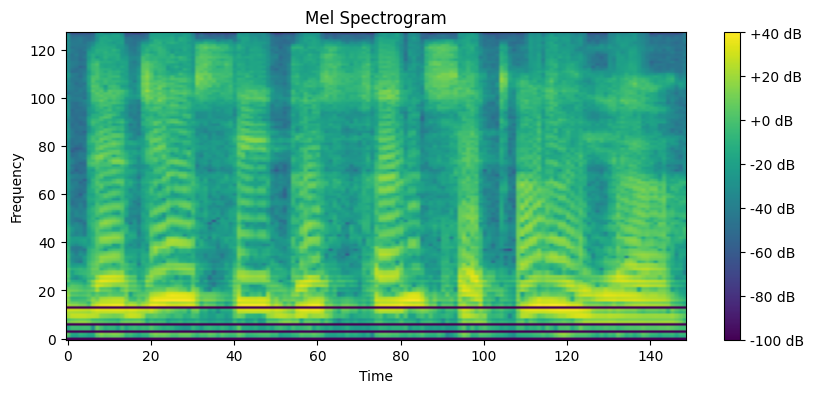

Real Audio Sample:


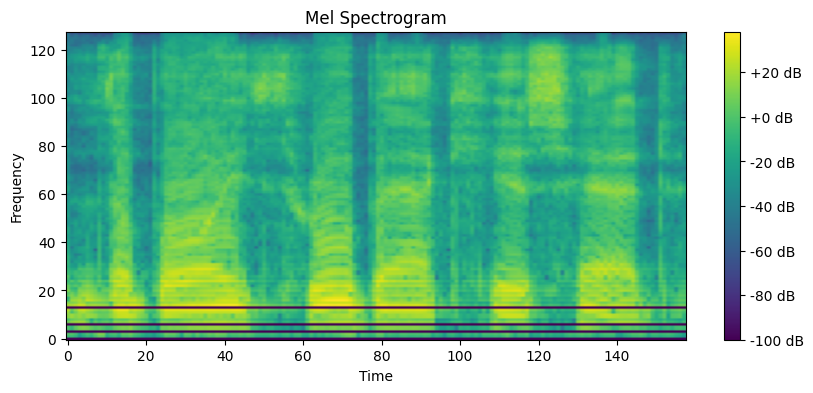

In [ ]:
# Select one fake and one real sample from the training set
fake_sample = train_df[train_df ["label"] == 0].sample(1).iloc[0]
real_sample = train_df[train_df ["label"] == 1].sample(1).iloc[0]
# Function to plot spectrogram
def plot_spectrogram(audio_path):
    waveform, sr = torchaudio.load(audio_path)
    mel_spec = MelSpectrogram (sample_rate=sr) (waveform)
    mel_db = AmplitudeToDB () (mel_spec)

    plt.figure(figsize=(10, 4))
    spec = plt.imshow(mel_db.squeeze().numpy(), aspect="auto", origin="lower", cmap="viridis")
    plt.colorbar(spec, format="%+2.0f dB")
    plt.title("Mel Spectrogram")
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.show()
# Display fake sample
print("Fake Audio Sample:")
display (Audio(fake_sample["audio_path"]))
plot_spectrogram(fake_sample["audio_path"])
# Display real sample
print("Real Audio Sample:")
display (Audio(real_sample["audio_path"]))
plot_spectrogram(real_sample["audio_path"])

/tmp/ipython-input-10-3809824123.py:62: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=frac, random_state=42))
/tmp/ipython-input-10-3809824123.py:62: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=frac, random_state=42))
/tmp/ipython-input-10-3809824123.py:62: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavi

Epoch 1/5 - Train Loss:  3.1677 - Validation Loss: 0.6506 - Validation Accuracy:  0.6874
Epoch 2/5 - Train Loss:  0.5342 - Validation Loss: 0.5965 - Validation Accuracy:  0.7307
Epoch 3/5 - Train Loss:  0.4192 - Validation Loss: 0.5876 - Validation Accuracy:  0.7288
Epoch 4/5 - Train Loss:  0.2777 - Validation Loss: 0.7741 - Validation Accuracy:  0.6271
Epoch 5/5 - Train Loss:  0.2005 - Validation Loss: 0.6177 - Validation Accuracy:  0.7382


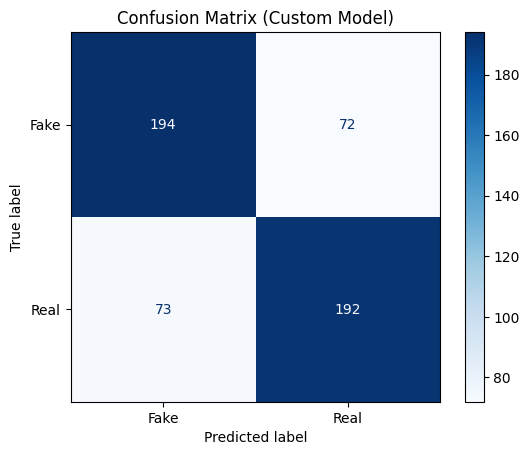

Classification Report: 
              precision    recall  f1-score   support

        Fake       0.73      0.73      0.73       266
        Real       0.73      0.72      0.73       265

    accuracy                           0.73       531
   macro avg       0.73      0.73      0.73       531
weighted avg       0.73      0.73      0.73       531



In [ ]:
class AudioDatasetCustom(Dataset):
    def __init__(self, df, max_length=16000): # Fixed method name
        self.audio_paths = df ["audio_path"].tolist()
        self.labels = df ["label"].tolist()
        self.max_length = max_length
    def __len__(self):
        return len(self.audio_paths)
    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]
        label = self.labels[idx]

        try:
            # Load and process audio
            waveform, sr = torchaudio.load(audio_path)
            if sr != 16000:
                waveform = torchaudio.transforms. Resample(orig_freq=sr, new_freq=16000)(waveform)
            waveform = waveform.squeeze (0)
            #Truncate or pad the waveform
            if waveform.shape[0] > self.max_length:
                waveform = waveform [:self.max_length]
            else:
                waveform = F.pad(waveform, (0, self.max_length - waveform.shape[0]))
        except Exception as e:
          print (f"Error loading audio file: {audio_path}. Skipping this file. Error: {e}")
          return self.__getitem__((idx + 1) % len(self)) # Retry with the next file

        return waveform, label # Return waveform without the extra channel dimension

# Step 2: Define the Custom Model
class AudioClassifier (nn.Module):
    def __init__(self, num_classes=2):
        super(AudioClassifier, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, stride=2, padding=2)
        self.bn1 = nn. BatchNorm1d (16)
        self.conv2 = nn.Conv1d (16, 32, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn. BatchNorm1d (32)
        self.conv3 = nn.Conv1d (32, 64, kernel_size=5, stride=2, padding=2)
        self.bn3 = nn. BatchNorm1d (64)
        # Calculate the flattened size
        # Input size: 16,000
        feature_map_size = 16000
        for _ in range(3): # 3 convolutional layers.
            feature_map_size = (feature_map_size - 5 + 2 * 2) // 2 + 1
        self. flattened_size = feature_map_size* 64
        self.fc1 = nn. Linear(self. flattened_size, 128)
        self.fc2 = nn. Linear (128, num_classes)
        self.dropout = nn. Dropout (0.3)
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu (self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1) # Flatten the output
        x = F.relu(self.fc1(x))
        x = self.dropout (x)
        x = self.fc2(x)
        return x

# Helper function to sample data
def sample_dataframe (df, frac=0.2):
    return (
        df.groupby("label", group_keys=False, as_index=False)
        .apply(lambda x: x.sample(frac=frac, random_state=42))
        .reset_index(drop=True)
)
# Step 3: Create datasets and loaders
train_df_20_train = sample_dataframe(train_df, frac=0.2)
train_df_20_val = sample_dataframe(val_df, frac=0.2)
test_df_20 = sample_dataframe(test_df, frac=0.2)
train_dataset_20_train = AudioDatasetCustom(train_df_20_train)
train_dataset_20_val = AudioDatasetCustom(train_df_20_val)
test_dataset_20 = AudioDatasetCustom(test_df_20)
train_loader_20 = DataLoader(train_dataset_20_train, batch_size=32, shuffle=True)
val_loader_20 = DataLoader(train_dataset_20_val, batch_size=32, shuffle=False)
test_loader_20 = DataLoader(test_dataset_20, batch_size=32, shuffle=False)

# Step 4: Compute Class Weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]), # Convert the list to a NumPy array
    y=train_df_20_train ["label"].values
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch. tensor (class_weights, dtype=torch.float).to(device)

# Training and Validation
def train_and_validate_model(model, train_loader, val_loader, num_epochs, learning_rate, class_weights):
    model.to(device)
    optimizer = optim. Adam (model.parameters(), lr=learning_rate, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss (weight=class_weights)

    for epoch in range (num_epochs):
        # Training phase
        model.train()
        total_loss = 0
        for waveforms, labels in train_loader:
            waveforms, labels = waveforms.to(device), labels.to(device)
            waveforms = waveforms.unsqueeze(1) # Add channel dimension

            optimizer.zero_grad()
            outputs = model (waveforms)
            loss = criterion (outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for waveforms, labels in val_loader:
                waveforms, labels = waveforms.to (device), labels.to(device)
                waveforms = waveforms.unsqueeze(1) # Add channel dimension
                outputs = model (waveforms)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.argmax (outputs, dim=-1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu (). numpy())
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = accuracy_score (all_labels, all_preds)

        print (f"Epoch {epoch+1}/{num_epochs} - "
            f"Train Loss: {avg_train_loss: .4f} - "
            f"Validation Loss: {avg_val_loss:.4f} - "
            f"Validation Accuracy: {val_accuracy: .4f}")
    return model

custom_model = AudioClassifier (num_classes=2)
trained_model = train_and_validate_model(custom_model, train_loader_20, val_loader_20, num_epochs=5, learning_rate=1e-3, class_weights=class_weights)
# Evaluate the model
def evaluate_model (model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for waveforms, labels in test_loader:
            waveforms, labels = waveforms.to(device), labels.to(device)
            waveforms = waveforms.unsqueeze(1) # Add channel dimension
            outputs = model (waveforms)
            preds = torch.argmax (outputs, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu (). numpy())
    return all_labels, all_preds
# Test evaluation
labels_20, preds_20 = evaluate_model(trained_model, test_loader_20)

# Display Confusion Matrix and Report
cm = confusion_matrix (labels_20, preds_20)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Custom Model)")
plt.show()
print("Classification Report: ")
print (classification_report (labels_20, preds_20, target_names=["Fake", "Real"]))

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
import numpy as np
import itertools

# --- Configuration ---
models = ["facebook/wav2vec2-base"]
learning_rates = [3e-5]
optimizers = ["adam"]
epochs_list = [1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

param_combinations = list(itertools.product(models, learning_rates, optimizers, epochs_list))

# --- Class Weights ---
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=train_df_20_train["label"].values
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# --- Custom Classifier Using Wav2Vec2 Features ---
class Wav2Vec2Classifier(nn.Module):
    def __init__(self, base_model_name, num_classes=2):
        super(Wav2Vec2Classifier, self).__init__()
        self.feature_extractor = Wav2Vec2Model.from_pretrained(base_model_name)
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_extractor.config.hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, input_values, attention_mask=None):
        features = self.feature_extractor(input_values=input_values, attention_mask=attention_mask)
        cls_rep = features.last_hidden_state.mean(dim=1)  # average pooling
        return self.classifier(cls_rep)

# --- Train + Evaluate Function ---
def train_custom_wav2vec2(model_name, learning_rate, optimizer_name, num_epochs,
                          train_loader, val_loader, class_weights):

    processor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
    model = Wav2Vec2Classifier(model_name).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate) if optimizer_name == "adam" else \
                torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    criterion = nn.CrossEntropyLoss(weight=class_weights)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0

        for waveforms, labels in train_loader:
            waveforms, labels = waveforms.to(device), labels.to(device)

            if waveforms.ndim == 3:
                waveforms = waveforms.squeeze(1)

            inputs = processor(waveforms.cpu().numpy(), sampling_rate=16000, return_tensors="pt", padding=True)
            input_values = inputs.input_values.to(device)
            attention_mask = inputs.attention_mask.to(device) if "attention_mask" in inputs else None

            optimizer.zero_grad()
            outputs = model(input_values, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(train_loader):.4f}")

        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for waveforms, labels in val_loader:
                waveforms, labels = waveforms.to(device), labels.to(device)
                if waveforms.ndim == 3:
                    waveforms = waveforms.squeeze(1)

                inputs = processor(waveforms.cpu().numpy(), sampling_rate=16000, return_tensors="pt", padding=True)
                input_values = inputs.input_values.to(device)
                attention_mask = inputs.attention_mask.to(device) if "attention_mask" in inputs else None

                outputs = model(input_values, attention_mask)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        acc = accuracy_score(all_labels, all_preds)
        print(f"Validation Accuracy: {acc:.4f}")
        print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))
        print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=['Fake', 'Real']))

# --- Train Loop ---
for model_name, lr, opt, epochs in param_combinations:
    print(f"\nTraining {model_name} with lr={lr}, optimizer={opt}, epochs={epochs}")
    train_custom_wav2vec2(model_name, lr, opt, epochs, train_loader_20, val_loader_20, class_weights)


Training facebook/wav2vec2-base with lr=3e-05, optimizer=adam, epochs=1


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

Epoch 1/1 - Loss: 0.6003
Validation Accuracy: 0.8230
Confusion Matrix:
 [[220  46]
 [ 48 217]]
Classification Report:
               precision    recall  f1-score   support

        Fake       0.82      0.83      0.82       266
        Real       0.83      0.82      0.82       265

    accuracy                           0.82       531
   macro avg       0.82      0.82      0.82       531
weighted avg       0.82      0.82      0.82       531



In [ ]:
# 1. training and validation DataFrames
def sample_dataframe (df, frac):
    return df.groupby("label", group_keys=False).apply(
        lambda x: x.sample (frac=frac, random_state=42)
    ).reset_index(drop=True)

# 2. Define a custom PyTorch Dataset
class AudioDataset (Dataset):
    def __init__(self, df, max_length=16000):
        self.audio_paths = df["audio_path"].tolist()
        self.labels =df["label"].tolist()
        self.max_length = max_length

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        audio_path = self.audio_paths [idx]
        label = self.labels[idx]

        # Load and process audio
        waveform, sr = torchaudio.load(audio_path)
        if sr != 16000:
            waveform = torchaudio.transforms. Resample (orig_freq=sr, new_freq=16000) (waveform)
        waveform = waveform. squeeze (0)

        # Truncate or pad the waveform
        if waveform.shape[0] > self.max_length:
            waveform = waveform[: self.max_length]
        else:
            waveform = torch.nn.functional.pad(waveform, (0, self.max_length - waveform.shape[0]))
        return waveform, label

/tmp/ipython-input-15-3239632697.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("label", group_keys=False).apply(
/tmp/ipython-input-15-3239632697.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("label", group_keys=False).apply(
/tmp/ipython-input-15-3239632697.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is dep

 20% of training data: 1592 samples
 20% of training data validation: 531 samples
 20% of testing data: 531 samples
Training the best model (facebook/wav2vec2-base) with 20% of the training dataset...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch (epoch+1)/1 - Loss: 0.5322-  Validation Accuracy: 0.9115


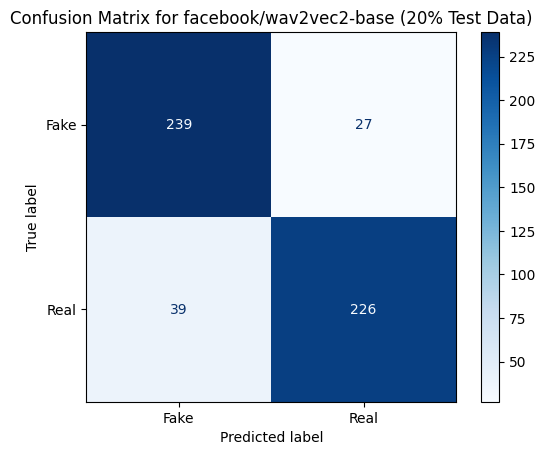

Classification Report:
              precision    recall  f1-score   support

        Fake       0.86      0.90      0.88       266
        Real       0.89      0.85      0.87       265

    accuracy                           0.88       531
   macro avg       0.88      0.88      0.88       531
weighted avg       0.88      0.88      0.88       531



In [ ]:
train_df_20_train = sample_dataframe (train_df, frac=0.2)
train_df_20_val = sample_dataframe (val_df, frac=0.2)
test_df_20 = sample_dataframe (test_df, frac=0.2)
print (f" 20% of training data: {len(train_df_20_train)} samples")
print (f" 20% of training data validation: {len(train_df_20_val)} samples")
print (f" 20% of testing data: {len(test_df_20)} samples")
# Step 3: Create PyTorch Datasets and Dataloaders
train_dataset_20_train = AudioDataset (train_df_20_train)
train_dataset_20_val = AudioDataset (train_df_20_val)
test_dataset_20 = AudioDataset (test_df_20)

train_loader_20 = DataLoader (train_dataset_20_train, batch_size=64, shuffle=True)
val_loader_20 = DataLoader (train_dataset_20_val, batch_size=64, shuffle=False)
test_loader_20 = DataLoader(test_dataset_20, batch_size=64, shuffle=False)
# Step 4: Compute Class Weights for Weighted Loss
class_weights = compute_class_weight(
    class_weight="balanced",
    classes = np.array([0, 1]), # Convert the list to a NumPy array
    y=train_df_20_train ["label"].values # Labels from the training DataFrame
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
# Step 5: Define Training Function
def train_model_on_20(model_name, learning_rate, optimizer_name, num_epochs, train_loader, val_loader, class_weights):
    # Load processor and model
    processor = AutoFeatureExtractor.from_pretrained(model_name)
    # Load model with ignore_mismatched_sizes=True
    model = AutoModelForAudioClassification.from_pretrained(
        model_name,
        num_labels=2, # Update to match your dataset's number of classes
        ignore_mismatched_sizes=True
    )

    model.to(device)
    # Define optimizer with regularization (weight decay)
    optimizer = torch.optim.Adam (model. parameters (), lr=learning_rate, weight_decay=1e-4)
    # Define weighted loss function
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

    # Training loop
    for epoch in range (num_epochs):
        model.train()
        total_loss = 0
        for waveforms, labels in train_loader:
            waveforms, labels = waveforms.to(device), labels.to(device)

            optimizer.zero_grad()
            inputs = processor(
                waveforms.cpu ().numpy(), # Convert to numpy
                sampling_rate=16000,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length = 16000 # Ensure the max length matches training
            ).to(device)
            outputs = model(**inputs)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation step
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for waveforms, labels in val_loader:
                waveforms, labels = waveforms.to(device), labels.to(device)
                inputs = processor(
                    waveforms.cpu().numpy(), # Convert to numpy
                    sampling_rate=16000,
                    return_tensors="pt",
                    padding=True,
                    truncation=True,
                    max_length=16000# Ensure max_length matches training
                ).to(device)
                outputs = model (**inputs)
                preds = torch.argmax(outputs.logits, dim=-1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        val_accuracy = accuracy_score(all_labels, all_preds)
        print(f"Epoch (epoch+1)/{num_epochs} - Loss: {total_loss/ len(train_loader):.4f}-  Validation Accuracy: {val_accuracy:.4f}")
    return model, processor
#Step 6: Train the Best Model on 20% Training Data
best_model_name = "facebook/wav2vec2-base"
best_learning_rate = 0.00005
best_optimizer = "adam"
best_epochs = 1
print (f"Training the best model ({best_model_name}) with 20% of the training dataset...")
trained_model, trained_processor = train_model_on_20(
best_model_name, best_learning_rate, best_optimizer, best_epochs, train_loader_20, val_loader_20, class_weights
)
#Step 7: Evaluate the Trained Model on the Test Dataset
def evaluate_model_on_test (model, processor, test_loader, max_length=16000):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for waveforms, labels in test_loader:
            waveforms, labels = waveforms.to(device), labels.to (device)
            inputs = processor(
                waveforms.cpu().numpy(), # Convert to numpy
                sampling_rate=16000,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=max_length # Specify max_length explicitly
            )
            inputs = {key: val.to (device) for key, val in inputs.items()}
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds
labels_20, preds_20 = evaluate_model_on_test (trained_model, trained_processor, test_loader_20)

#Step 8: Display Confusion Matrix and Classification Report
cm = confusion_matrix(labels_20, preds_20)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix for {best_model_name} (20% Test Data)")
plt.show()
print("Classification Report:")
print(classification_report(labels_20, preds_20, target_names=["Fake", "Real"]))

In [ ]:
# Save the best model to google drive
from google.colab import drive
drive.mount('/content/drive')
save_directory = "/content/drive/MyDrive/best_model_wav2vec2"
trained_model.save_pretrained(save_directory)
trained_processor.save_pretrained(save_directory)
print (f"Model and processor saved to Google Drive: {save_directory}")

In [ ]:
#start from here

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Step to write your Streamlit code into app.py in Colab
code = """
import streamlit as st
import torchaudio
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from transformers import AutoModelForAudioClassification, AutoFeatureExtractor

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Add custom CSS for dark background
st.markdown(
    '''
    <style>
    .stApp {
        background-color: #121212;
        color: white;
    }
    .css-18e3th9 {
        background-color: #1e1e1e !important;
    }
    .block-container {
        background-color: rgba(30, 30, 30, 0.9);
        padding: 2rem;
        border-radius: 10px;
    }
    .stButton>button {
        background-color: #0a84ff;
        color: white;
        font-weight: bold;
    }
    </style>
    ''',
    unsafe_allow_html=True
)

@st.cache_resource
def load_model_and_processor():
    model = AutoModelForAudioClassification.from_pretrained("/content/drive/MyDrive/best_model_wav2vec2", local_files_only=True).to(device)
    processor = AutoFeatureExtractor.from_pretrained("/content/drive/MyDrive/best_model_wav2vec2", local_files_only=True)
    return model, processor

model, processor = load_model_and_processor()

def classify_audio(audio_path, model, processor, max_length=16000):
    waveform, sr = torchaudio.load(audio_path)
    if sr != 16000:
        waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)(waveform)
    waveform = waveform.squeeze(0)
    if waveform.shape[0] > max_length:
        waveform = waveform[:max_length]
    else:
        waveform = torch.nn.functional.pad(waveform, (0, max_length - waveform.shape[0]))

    inputs = processor(
        waveform.unsqueeze(0).numpy(),
        sampling_rate=16000,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_length
    )
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred = torch.argmax(logits, dim=-1).item()

    label_map = {0: "Fake", 1: "Real"}
    return label_map[pred], waveform, sr

st.title("Deep Fake Audio Detection")
st.write("Upload a .wav audio file to classify it as **Real** or **Fake**")

uploaded_file = st.file_uploader("Choose a WAV audio file", type=["wav"])

if uploaded_file is not None:
    with open("temp.wav", "wb") as f:
        f.write(uploaded_file.read())

    st.audio("temp.wav")
    prediction, waveform, sr = classify_audio("temp.wav", model, processor)
    st.success(f"Predicted Label: {prediction}")

    # Generate and display spectrogram
    st.subheader("Spectrogram")
    fig, ax = plt.subplots()
    spec = torchaudio.transforms.MelSpectrogram(sample_rate=sr)(waveform.unsqueeze(0))
    spec_db = torchaudio.transforms.AmplitudeToDB()(spec)
    ax.imshow(spec_db[0].numpy(), cmap='viridis', aspect='auto', origin='lower')
    ax.set_title("Mel Spectrogram", color='white')
    ax.set_xlabel("Frames", color='white')
    ax.set_ylabel("Frequency bins", color='white')
    ax.tick_params(colors='white')
    fig.patch.set_facecolor('#121212')
    st.pyplot(fig)

    # Display model accuracy
    st.subheader("Model Performance on Training Data")
    st.write("Accuracy: 0.88")

    # Display an image (make sure the image path is correct)
    st.image("/content/Screenshot 2025-06-28 152344.png", caption="Model Visualization", use_container_width=True)
"""

with open("app.py", "w") as f:
    f.write(code)
print("✅ app.py with dark theme created successfully!")


✅ app.py with dark theme created successfully!


In [ ]:
!ls


 app.py   drive   sample_data  'Screenshot 2025-06-28 152344.png'


In [ ]:
!pip install streamlit pyngrok


  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached GitPython-3.1.44-py3-none-any.whl.metadata (13 kB)
  Using cached pydeck-0.9.1-py2.py3-none-any.whl.metadata (4.1 kB)
  Using cached gitdb-4.0.12-py3-none-any.whl.metadata (1.2 kB)
Using cached blinker-1.9.0-py3-none-any.whl (8.5 kB)
Using cached GitPython-3.1.44-py3-none-any.whl (207 kB)
Using cached pydeck-0.9.1-py2.py3-none-any.whl (6.9 MB)
Using cached gitdb-4.0.12-py3-none-any.whl (62 kB)
  Attempting uninstall: blinker
    Found existing installation: blinker 1.4
error: uninstall-distutils-installed-package

× Cannot uninstall blinker 1.4
╰─> It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [ ]:
!pip install --quiet streamlit --no-deps


In [ ]:
from pyngrok import conf
conf.get_default().auth_token = "2z85CqkJ7eknhdOY2jRFUnUXatC_tRx9xJT9DubQfaF9gk4T"


In [ ]:
import time
import subprocess
from pyngrok import ngrok

# Start Streamlit in the background
process = subprocess.Popen(["streamlit", "run", "app.py"])
time.sleep(5)  # Wait a few seconds for Streamlit to launch

# Start ngrok tunnel to Streamlit
public_url = ngrok.connect(8501)
print(f"🔗 Streamlit app is live at: {public_url}")


🔗 Streamlit app is live at: NgrokTunnel: "https://a6417500b660.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
#final exercise to predict user audio file
from google.colab import drive
from google.colab import files
import torchaudio
import torch.nn.functional as F

In [ ]:
# Upload a new audio file
uploaded = files.upload() # Select a wav file from your local machine
# Get the uploaded file path
audio_path = list(uploaded.keys())[0]
print(f"Uploaded file: {audio_path}")
def classify_audio(audio_path, model, processor, max_length=16000):
    # Load and preprocess the audio
    waveform, sr = torchaudio.load(audio_path)
    if sr != 16000:
        waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)(waveform)
    waveform = waveform.squeeze (0) # Remove the channel dimension

    # Truncate or pad to match max_length
    if waveform.shape[0] > max_length:
        waveform = waveform[:max_length]
    else:
        waveform = F.pad (waveform, (0, max_length - waveform.shape[0]))
    # Prepare the input for the model
    inputs = processor (
        waveform.unsqueeze (0).numpy(), # Add batch dimension
        sampling_rate=16000,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_length
    )
    inputs = {key: val.to (device) for key, val in inputs.items()}

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred = torch.argmax(logits, dim=-1).item()

    # Convert the prediction to label
    label_map = {0: "Fake", 1: "Real"}
    return label_map[pred]

Saving recording13.wav_norm_mono.wav to recording13.wav_norm_mono (1).wav
Uploaded file: recording13.wav_norm_mono (1).wav


In [ ]:
# Load the saved model and processor
from transformers import AutoModelForAudioClassification, AutoFeatureExtractor
import torch

save_directory = "/content/drive/MyDrive/best_model_wav2vec2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loaded_model = AutoModelForAudioClassification.from_pretrained(save_directory, local_files_only=True).to(device)
loaded_processor = AutoFeatureExtractor.from_pretrained(save_directory, local_files_only=True)

# Classify the uploaded audio file
prediction = classify_audio(audio_path, loaded_model, loaded_processor)
print(f"Predicted Label: {prediction}")

Predicted Label: Fake


In [ ]:
!streamlit run app.py


/bin/bash: line 1: streamlit: command not found


In [ ]:
!pip install pyngrok --quiet


In [ ]:
!pip install streamlit pyngrok --quiet


error: uninstall-distutils-installed-package

× Cannot uninstall blinker 1.4
╰─> It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [ ]:
!pip install streamlit --quiet

error: uninstall-distutils-installed-package

× Cannot uninstall blinker 1.4
╰─> It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [ ]:
from pyngrok import conf
conf.get_default().auth_token = "2z85CqkJ7eknhdOY2jRFUnUXatC_tRx9xJT9DubQfaF9gk4T"
